In [29]:
# =========================================
# 1. librerías
# =========================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
import joblib


In [30]:
datos = pd.read_csv(filepath_or_buffer = "C:/Users/jenif/Downloads/beisbol.csv") 

In [31]:
datos.head()

,Unnamed: 0,equipos,bateos,runs
0,0,Texas,5659,855
1,1,Boston,5710,875
2,2,Detroit,5563,787
3,3,Kansas,5672,730
4,4,St.,5532,762



Valores nulos por columna:
Unnamed: 0    0
equipos       0
bateos        0
runs          0
dtype: int64

Columnas numéricas detectadas: ['Unnamed: 0', 'bateos', 'runs']
Columnas categóricas detectadas: ['equipos']


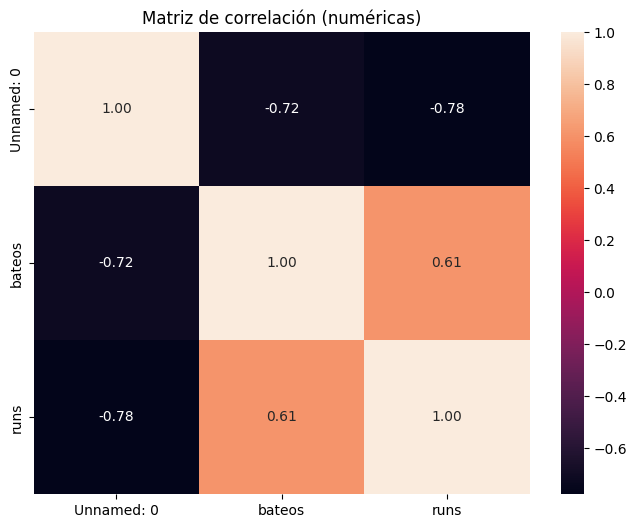

In [32]:
# =========================================
# 3. EDA rápido
# =========================================
print("\nValores nulos por columna:")
print(datos.isnull().sum())

numeric_cols = datos.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = datos.select_dtypes(include=['object', 'category']).columns.tolist()

print("\nColumnas numéricas detectadas:", numeric_cols)
print("Columnas categóricas detectadas:", cat_cols)

# Matriz de correlación
if len(numeric_cols) >= 2:
    plt.figure(figsize=(8,6))
    sns.heatmap(datos[numeric_cols].corr(), annot=True, fmt='.2f')
    plt.title('Matriz de correlación (numéricas)')
    plt.show()


In [33]:
# =========================================
# 4. Selección de variable objetivo
# =========================================
target_column = 'bateos'  # Cambiar si es necesario
X = datos.drop(columns=[target_column])
y = datos[target_column]


In [34]:
# =========================================
# 5. Preprocesamiento
# =========================================
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())  # Escalado necesario para regresión lineal
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


In [36]:
# =========================================
# 6. Pipeline con Regresión Lineal
# =========================================
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])



In [37]:
# =========================================
# 7. División train/test
# =========================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nTamaños train/test:", X_train.shape, X_test.shape)



Tamaños train/test: (24, 3) (6, 3)


In [38]:
# =========================================
# 8. Entrenamiento
# =========================================
pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [39]:
# =========================================
# 9. Evaluación
# =========================================
y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- MÉTRICAS EN TEST ---")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2:   {r2:.4f}")



--- MÉTRICAS EN TEST ---
MAE:  38.8748
RMSE: 46.1625
R2:   0.1834


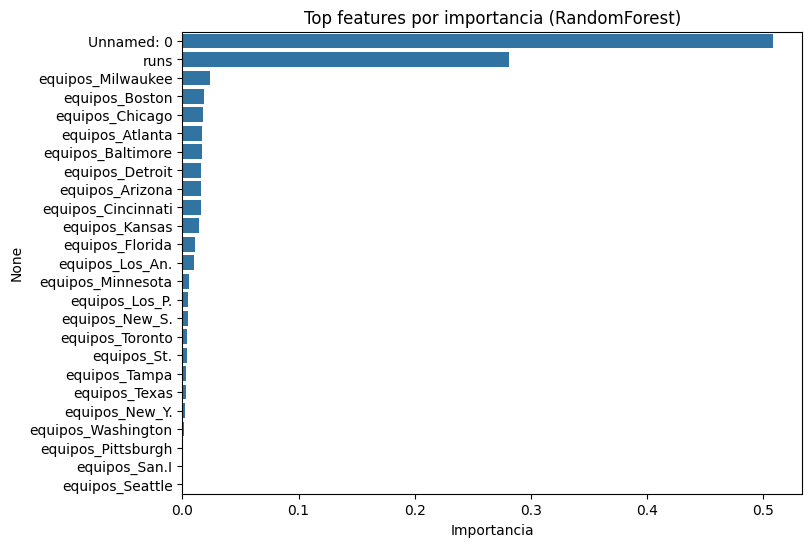

In [27]:
# ---------------------------
# Importancia de características (si aplica)
# ---------------------------
# Para obtener importancias, necesitamos obtener los nombres de columnas después del preprocesamiento.
try:
    # obtener nombres de features transformados
    pre = best_model.named_steps['preprocessor']
    # nombres numéricos
    num_cols = numeric_features
    # nombres categóricos transformados (onehot)
    cat_cols_trans = []
    if len(categorical_features) > 0:
        ohe = pre.named_transformers_['cat'].named_steps['onehot']
        cat_names = ohe.get_feature_names_out(categorical_features)
        cat_cols_trans = list(cat_names)
    feature_names = num_cols + cat_cols_trans

    rf = best_model.named_steps['model']
    importances = rf.feature_importances_
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(30)
    plt.figure(figsize=(8,6))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title('Top features por importancia (RandomForest)')
    plt.xlabel('Importancia')
    plt.show()
except Exception as e:
    print("No fue posible mostrar importancias de forma automática:", e)


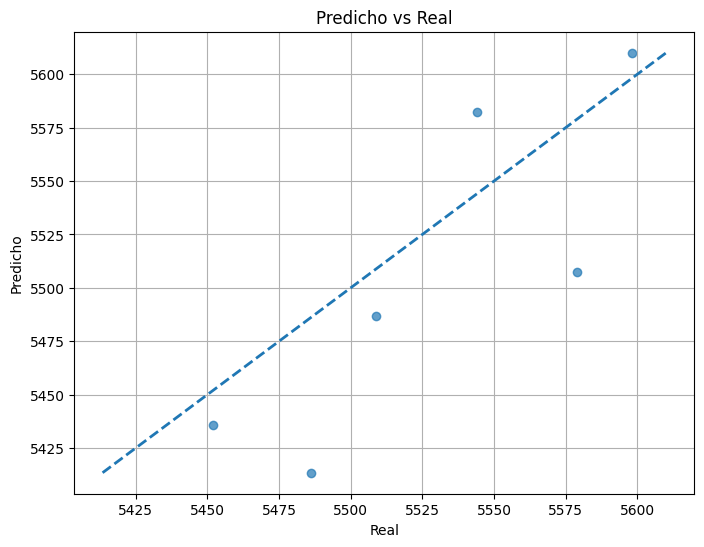

In [40]:
# =========================================
# 10. Gráficas
# =========================================
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', linewidth=2)
plt.xlabel('Real')
plt.ylabel('Predicho')
plt.title('Predicho vs Real')
plt.grid(True)
plt.show()


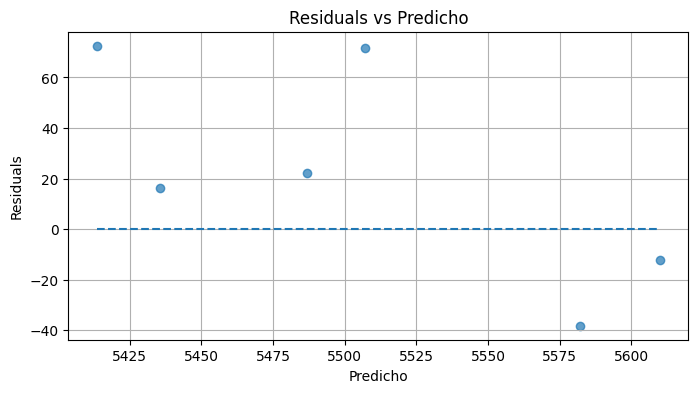

In [41]:

# Residuos
residuals = y_test - y_pred
plt.figure(figsize=(8,4))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.hlines(0, xmin=min(y_pred), xmax=max(y_pred), linestyles='--')
plt.xlabel('Predicho')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicho')
plt.grid(True)
plt.show()

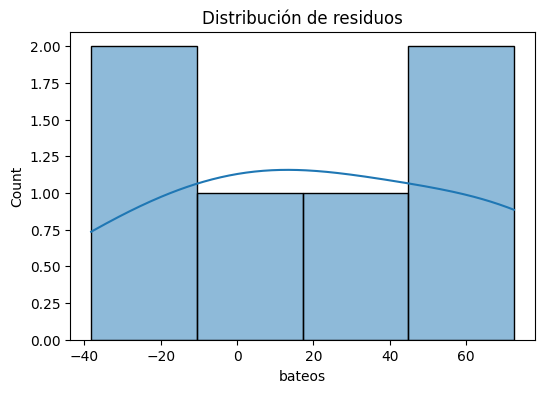

In [42]:
# Histograma de residuos
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title('Distribución de residuos')
plt.show()


In [43]:
# =========================================
# 11. Guardar modelo
# =========================================
os.makedirs('model', exist_ok=True)
model_path = os.path.join('model', 'linear_regression_beisbol.pkl')
joblib.dump(pipeline, model_path)
print("\nModelo guardado en:", model_path)


Modelo guardado en: model\linear_regression_beisbol.pkl
